<a href="https://colab.research.google.com/github/CurlyNikolai/Citybike_ml/blob/main/city_bike_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# City Bike Machine Learning

Welcome to the city bike machine learning project!

This code was created for the Machine Learning course student project at Aalto University. The purpose of this study is to investigate whether a valuable model can be attained from the Helsinki Regional Transport Authority’s (HSL) city-bike data and weather observations provided by the Finnish Meteorogical Institute (FMI), in order to better anticipate the need for a redistribution of bicycles to a specific city-bike-station. 


Let's put all our required imports in here.

In [2]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures   # function to generate polynomial and interaction features
from sklearn.linear_model import LinearRegression    # classes providing Linear Regression with ordinary squared error loss and Huber loss, respectively
from sklearn.model_selection import train_test_split, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error    
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.lines import Line2D
import calendar
int_to_weekday_map = {0 : "Mon", 1 : "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}

## The Data

The original data can be found from the following links:
1. [HSL city-bike data](https://www.hsl.fi/en/hsl/open-data) (CC BY 4.0)
2. [FMI weather observations](https://en.ilmatieteenlaitos.fi/download-observations) (CC BY 4.0)

### Read in the data
Let's start of by reading in the modified data, and taking a little peek of it:

In [3]:
# Read in the data
data = pd.read_csv("bike_data.csv", index_col=0)
pd.set_option("expand_frame_repr", False)
data = data[data["Departures"]>0]
print(data.columns)
print(data.head)

Index(['Year', 'Month', 'Day', 'Hour', 'Date', 'Weekday', 'Departures',
       'Returns', 'Air temperature', 'Rain intensity', 'Rain intensity class'],
      dtype='object')
<bound method NDFrame.head of         Year  Month  Day  Hour   Date  Weekday  Departures  Returns  Air temperature  Rain intensity  Rain intensity class
468     2016      5    2    15  05-02        0         4.0      2.0             15.5             0.0                   0.0
469     2016      5    2    15  05-02        0         4.0      2.0             15.5             0.0                   0.0
480     2016      5    2    16  05-02        0         2.0      2.0             15.3             0.0                   0.0
481     2016      5    2    16  05-02        0         2.0      2.0             15.3             0.0                   0.0
492     2016      5    2    17  05-02        0         2.0      3.0             12.6             0.0                   0.0
...      ...    ...  ...   ...    ...      ...         ...

Then let's further modify our data, by including annually normalized departures and returns, and a classifier for if it's a working day or weekend.

In [4]:
# Add normalized departure and return data (normalize by annual max)

# Normalize departures
yearly_max = data.groupby(["Year"]).Departures.max()
years = yearly_max.index.to_numpy()
maxval = yearly_max.values
yearly_max = pd.DataFrame(data={"Year": years, "Maxvalue": maxval})
data = data.merge(yearly_max, on=["Year"])
data["Normalized departures"] = data.Departures / data.Maxvalue
data.drop(['Maxvalue'], axis=1, inplace=True)

# Normalize returns
yearly_max = data.groupby(["Year"]).Returns.max()
years = yearly_max.index.to_numpy()
maxval = yearly_max.values
yearly_max = pd.DataFrame(data={"Year": years, "Maxvalue": maxval})
data = data.merge(yearly_max, on=["Year"])
data["Normalized returns"] = data.Returns / data.Maxvalue
data.drop(['Maxvalue'], axis=1, inplace=True)

# Add classifier for the weekday to specify between workday and weekend (0, 1)
data["Weekday classifier"] = np.where(data.Weekday < 5, 0, 1)

# Reorder the columns
data = data[["Year", "Month", "Day", "Hour", "Date", "Weekday", "Weekday classifier", "Departures", "Returns",
             "Normalized departures", "Normalized returns", "Air temperature", "Rain intensity", "Rain intensity class"]]

# Sanity check, look at the data
print(data.head)


<bound method NDFrame.head of        Year  Month  Day  Hour   Date  Weekday  Weekday classifier  Departures  Returns  Normalized departures  Normalized returns  Air temperature  Rain intensity  Rain intensity class
0      2016      5    2    15  05-02        0                   0         4.0      2.0               0.142857            0.086957             15.5             0.0                   0.0
1      2016      5    2    15  05-02        0                   0         4.0      2.0               0.142857            0.086957             15.5             0.0                   0.0
2      2016      5    2    16  05-02        0                   0         2.0      2.0               0.071429            0.086957             15.3             0.0                   0.0
3      2016      5    2    16  05-02        0                   0         2.0      2.0               0.071429            0.086957             15.3             0.0                   0.0
4      2016      5    2    17  05-02        0

### Data visualization

Next, let's visualize the data by plotting the number of departures against most features:

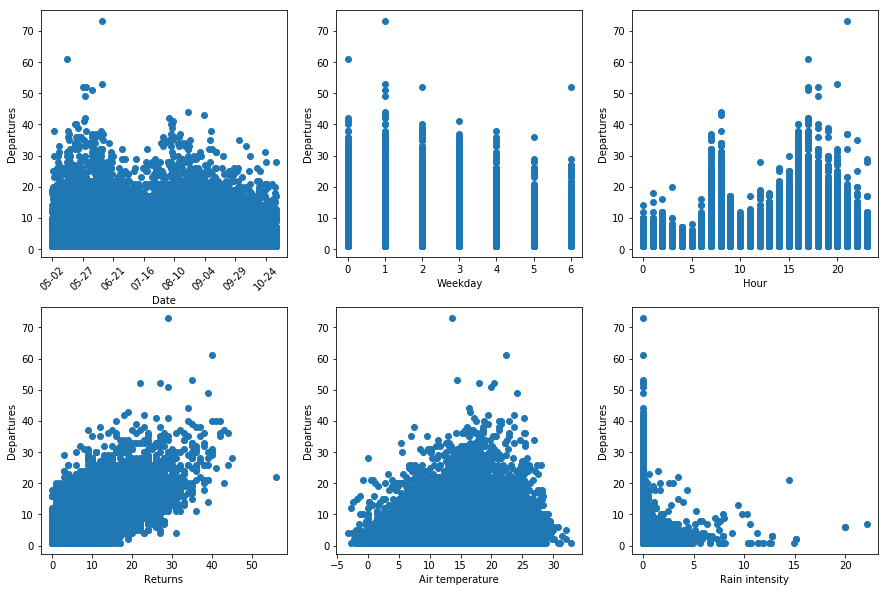

In [5]:
# Plot departures against Hour, Air temperature, Rain intensity, Weekday
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15), fig.set_figheight(10)
axs[0, 0].scatter(data.Date, data.Departures)
axs[0, 0].xaxis.set_major_locator(ticker.MaxNLocator(10))
axs[0, 0].set_ylabel("Departures")
axs[0, 0].set_xlabel("Date")
for tick in axs[0, 0].get_xticklabels(): tick.set_rotation(45)
axs[0, 1].scatter(data.Weekday, data.Departures)
axs[0, 1].set_ylabel("Departures")
axs[0, 1].set_xlabel("Weekday")
axs[0, 2].scatter(data.Hour, data.Departures)
axs[0, 2].set_ylabel("Departures")
axs[0, 2].set_xlabel("Hour")
axs[1, 0].scatter(data.Returns, data.Departures)
axs[1, 0].set_ylabel("Departures")
axs[1, 0].set_xlabel("Returns")
axs[1, 1].scatter(data["Air temperature"], data.Departures)
axs[1, 1].set_ylabel("Departures")
axs[1, 1].set_xlabel("Air temperature")
axs[1, 2].scatter(data["Rain intensity"], data.Departures)
axs[1, 2].set_ylabel("Departures")
axs[1, 2].set_xlabel("Rain intensity")
plt.show()

Then, let's add some transparency to better see the density of the datapoints, and colour depending on the rain intensity class:

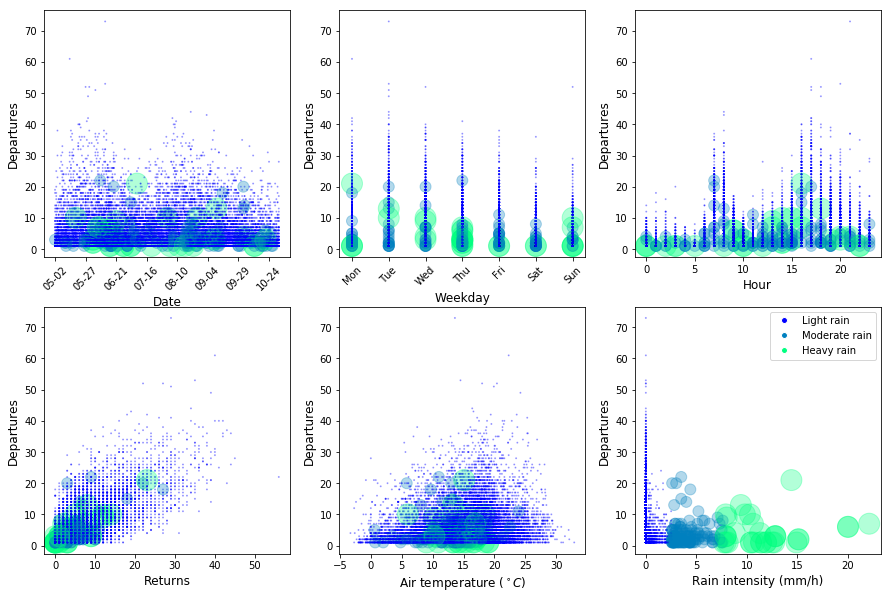

In [6]:
# Plot departures against Hour, Air temperature, Rain intensity, Weekday
fontsize = 12
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15), fig.set_figheight(10)
axs[0, 0].scatter(data.Date, data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[0, 0].xaxis.set_major_locator(ticker.MaxNLocator(10))
axs[0, 0].set_ylabel("Departures", fontsize=fontsize)
axs[0, 0].set_xlabel("Date", fontsize=fontsize)
for tick in axs[0, 0].get_xticklabels(): tick.set_rotation(45)
axs[0, 1].scatter(data.Weekday, data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[0, 1].set_ylabel("Departures", fontsize=fontsize)
axs[0, 1].set_xlabel("Weekday", fontsize=fontsize)
axs[0, 1].set_xticks([i for i in range(7)])
axs[0, 1].set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
for tick in axs[0, 1].get_xticklabels(): tick.set_rotation(45)
axs[0, 2].scatter(data.Hour, data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[0, 2].set_ylabel("Departures", fontsize=fontsize)
axs[0, 2].set_xlabel("Hour", fontsize=fontsize)
axs[1, 0].scatter(data.Returns, data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[1, 0].set_ylabel("Departures", fontsize=fontsize)
axs[1, 0].set_xlabel("Returns", fontsize=fontsize)
axs[1, 1].scatter(data["Air temperature"], data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[1, 1].set_ylabel("Departures", fontsize=fontsize)
axs[1, 1].set_xlabel("Air temperature ($^\circ C$)", fontsize=fontsize)
axs[1, 2].scatter(data["Rain intensity"], data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[1, 2].set_ylabel("Departures", fontsize=fontsize)
axs[1, 2].set_xlabel("Rain intensity (mm/h)", fontsize=fontsize)
cmap=plt.cm.winter
custom_markers = [Line2D([0], [0], color="w", markerfacecolor=cmap(0.0), marker='o'),
                  Line2D([0], [0], color="w", markerfacecolor=cmap(0.5), marker='o'),
                  Line2D([0], [0], color="w", markerfacecolor=cmap(1.0), marker='o')]
axs[1, 2].legend(custom_markers, ["Light rain", "Moderate rain", "Heavy rain"])
plt.savefig("data-summary.jpg", dpi=300, bbox_inches='tight')
plt.show()


Let's now instead colour the datapoints depending on the air temperature:

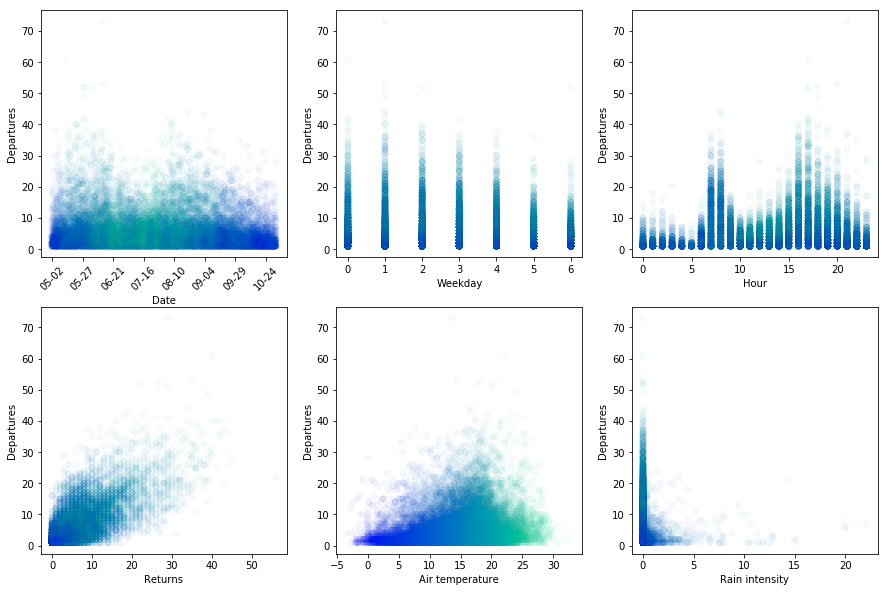

In [7]:
# Plot departures against Hour, Air temperature, Rain intensity, Weekday
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15), fig.set_figheight(10)
axs[0, 0].scatter(data.Date, data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[0, 0].xaxis.set_major_locator(ticker.MaxNLocator(10))
axs[0, 0].set_ylabel("Departures")
axs[0, 0].set_xlabel("Date")
for tick in axs[0, 0].get_xticklabels(): tick.set_rotation(45)
axs[0, 1].scatter(data.Weekday, data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[0, 1].set_ylabel("Departures")
axs[0, 1].set_xlabel("Weekday")
axs[0, 2].scatter(data.Hour, data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[0, 2].set_ylabel("Departures")
axs[0, 2].set_xlabel("Hour")
axs[1, 0].scatter(data.Returns, data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[1, 0].set_ylabel("Departures")
axs[1, 0].set_xlabel("Returns")
axs[1, 1].scatter(data["Air temperature"], data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[1, 1].set_ylabel("Departures")
axs[1, 1].set_xlabel("Air temperature")
axs[1, 2].scatter(data["Rain intensity"], data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[1, 2].set_ylabel("Departures")
axs[1, 2].set_xlabel("Rain intensity")
plt.show()


Let's also see how the mean amount of departures has changed throughout the years:

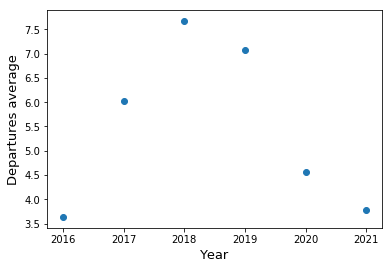

In [14]:
# Cell for investigating the popularity of bikes at Kaisaniemi, depending on year, and weekday on different years

data_grouped_mean = data.groupby(["Year"]).Departures.mean()
year = data_grouped_mean.index.to_numpy()
value = data_grouped_mean[year].values
plt.scatter(year, value)
plt.xlabel(r"Year", fontsize=13)
plt.ylabel(r"Departures average", fontsize=13)
plt.savefig("Covid_effect.jpg", dpi=300, bbox_inches='tight')
plt.show()

Covid unveils its ugly head here as well 👆

Let's now plot the departures against the hour of day, for every weekday:

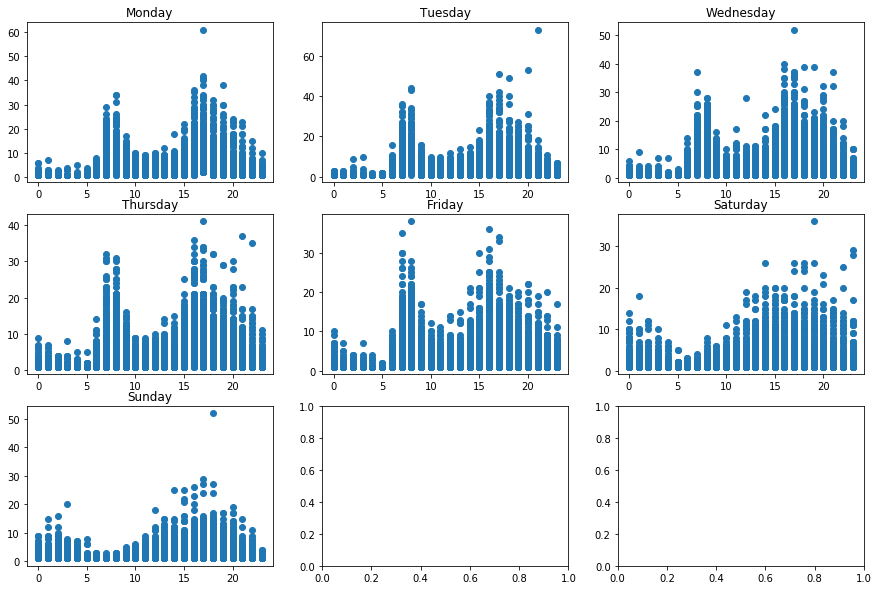

In [9]:
# Separate data into weekday data
data_weekday = [data[data.Weekday == i] for i in range(7)]

# Plot the departures for every hour, for every weekday
fig, axs = plt.subplots(3,3)
fig.set_figwidth(15); fig.set_figheight(10)
j, k = 0, 0
for i in range(7):
    if k==3: k = 0; j += 1
    axs[j, k].scatter(data_weekday[i].Hour, data_weekday[i].Departures)
    axs[j, k].set_title(list(calendar.day_name)[i])
    k+=1
plt.show()


What's interesting to see in the plot above is that we can clearly distuingish rush hours during the weekdays, and what's even more interesting to see is the little bump in departures during the night at the end of the week 😊

Let's separate the days into working days and weekends:

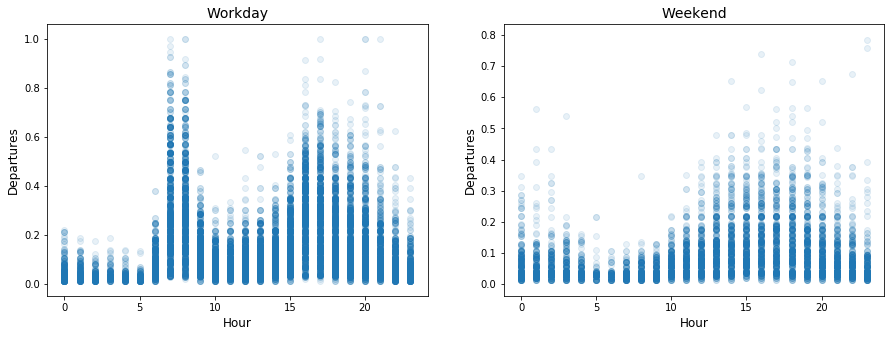

In [10]:
# Separate data into weekday data
data_weekday = [data[data["Weekday classifier"] == i] for i in range(2)]

# Plot the departures for every hour, for every weekday
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(5)
j, k = 0, 0
for i in range(2):
    axs[i].scatter(data_weekday[i].Hour, data_weekday[i]["Normalized departures"], alpha=0.1)
    axs[i].set_xlabel("Hour", fontsize=12)
    axs[i].set_ylabel("Departures", fontsize=12)
axs[0].set_title("Workday", fontsize=14)
axs[1].set_title("Weekend", fontsize=14)
plt.savefig("departures-all.jpg", dpi=300, bbox_inches='tight')
plt.show()


## The Model

Let's try out different degrees for polynomial regression on the upper contour of the departures data for workdays and weekends, storing the training and validation errors:

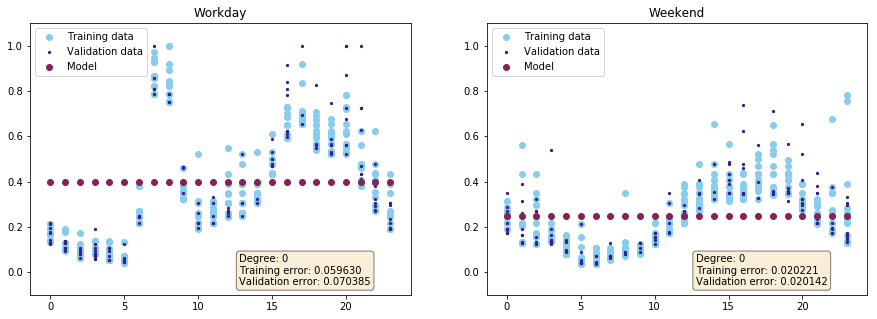

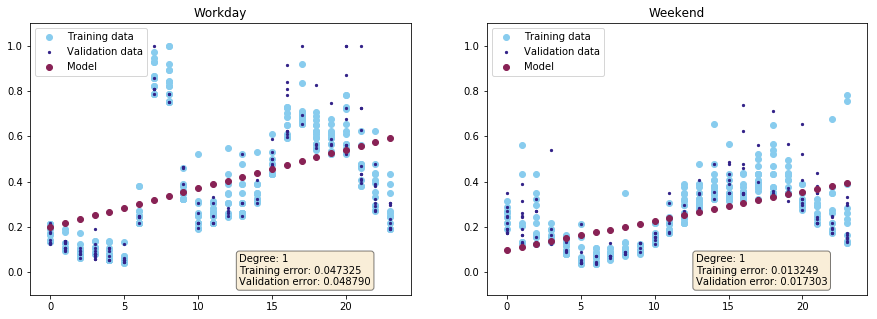

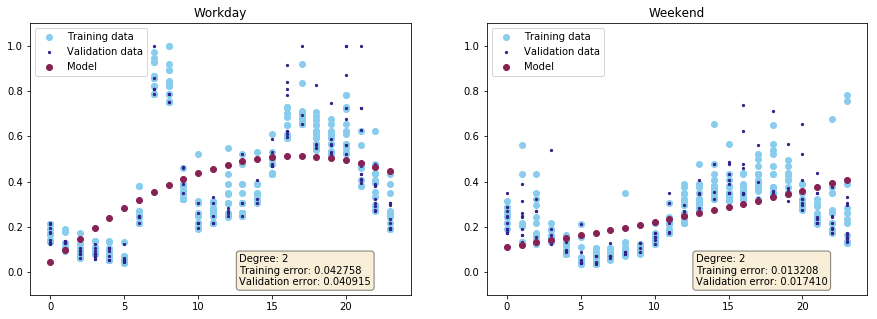

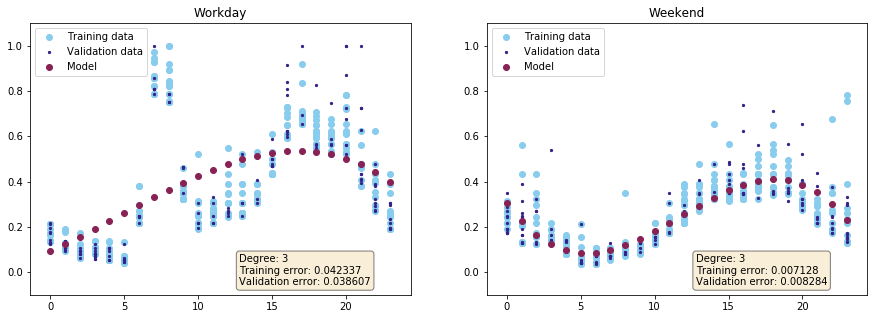

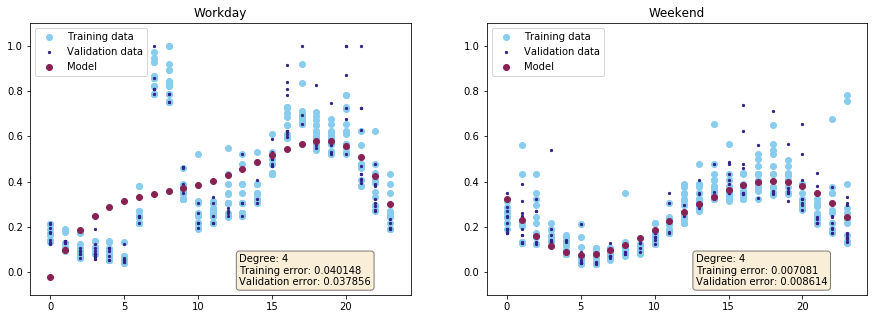

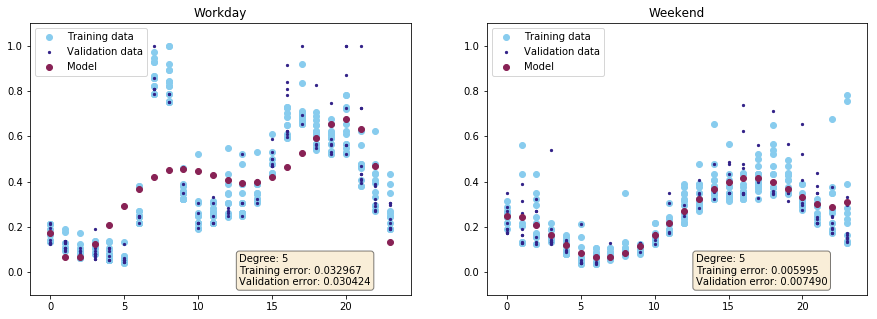

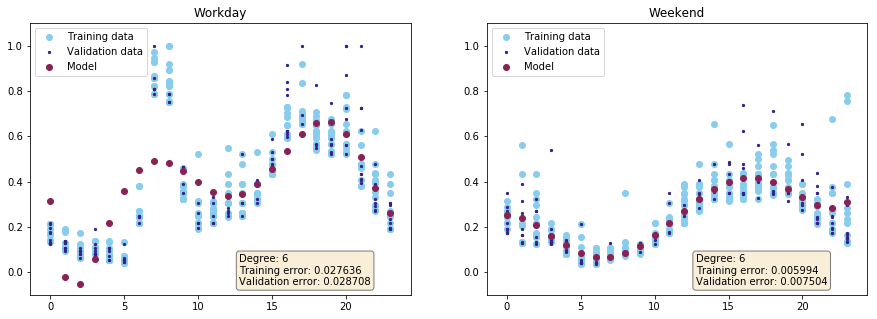

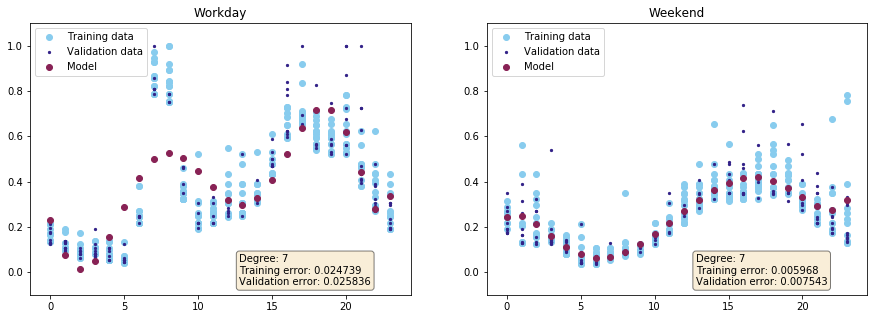

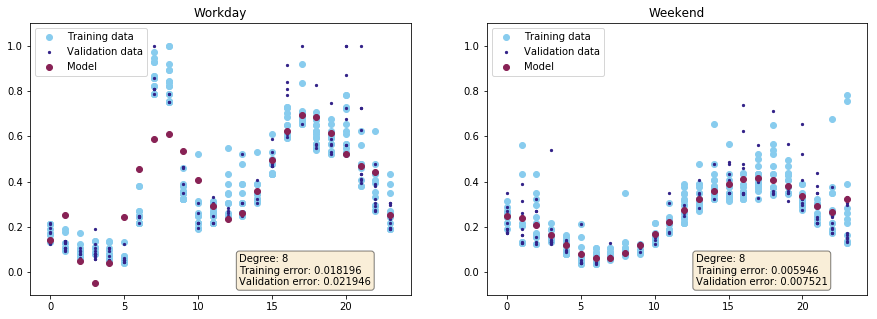

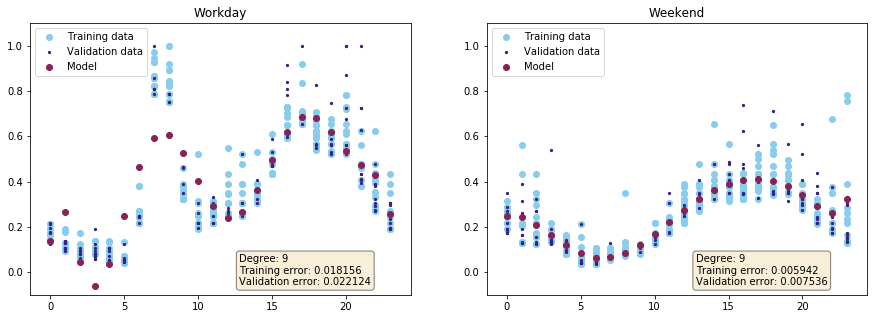

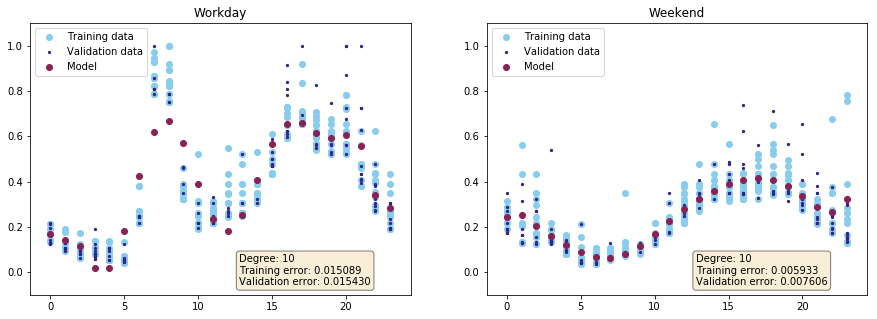

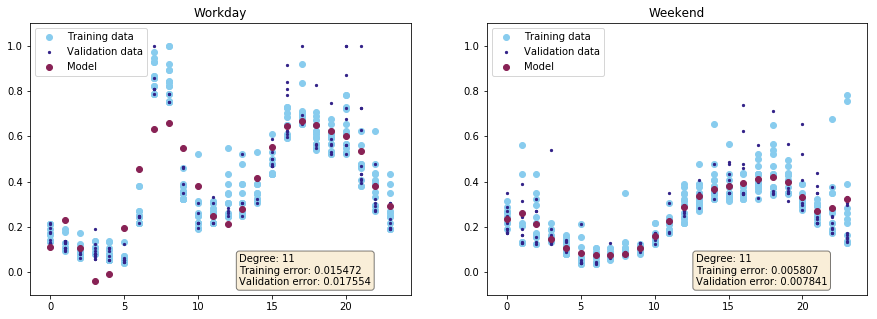

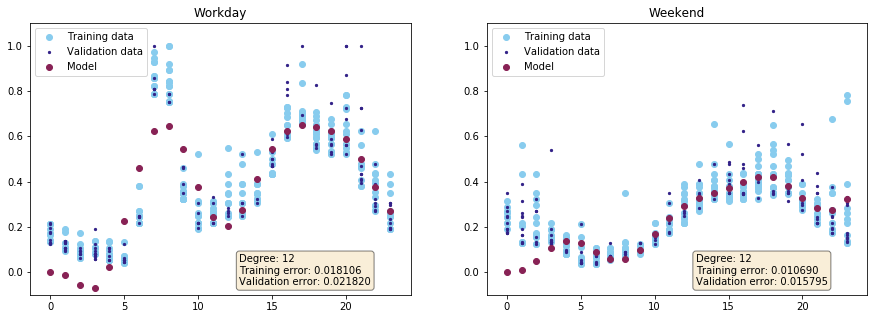

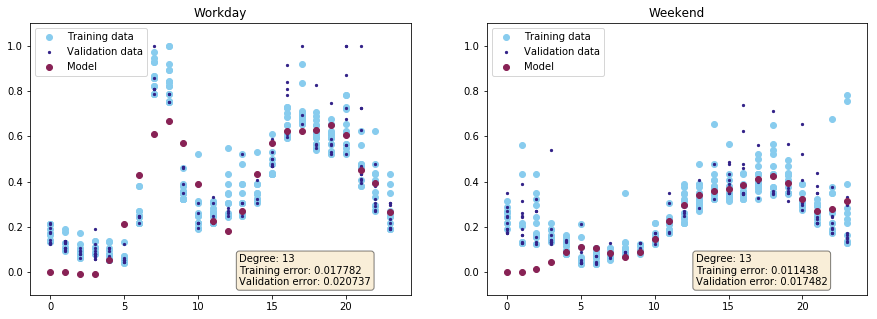

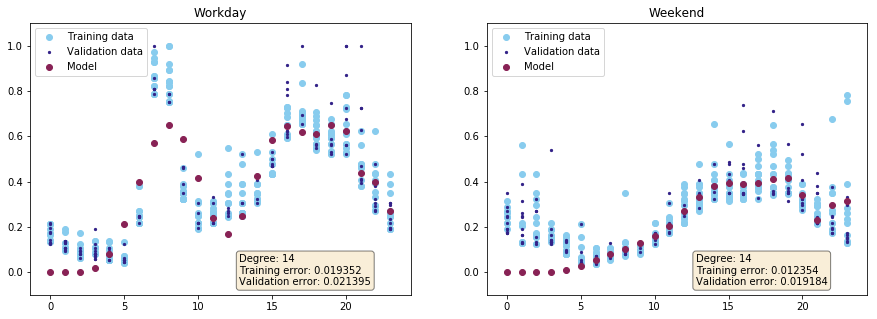

In [11]:
# Do the same thing as above, but split days into two categories: workday and weekend (0 and 1)

# Polynomial fit for the data where only the 20 max departure datapoints are taken into account for each hour during each weekday
nlargest = 20

data_largest = data.groupby(["Weekday classifier", "Hour"])[
    "Normalized departures"].nlargest(20)

tr_errors = {0 : [], 1 : []}
val_errors = {0: [], 1: []}
for deg in range(0, 15):
    fig, axs = plt.subplots(1, 2)
    fig.set_figwidth(15)
    fig.set_figheight(5)
    for day in range(2):
        y = data_largest[day].values
        X = data_largest[day].index.get_level_values(0).to_numpy().reshape(-1, 1)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
        
        poly = PolynomialFeatures(degree=deg)
        X_train_poly = poly.fit_transform(X_train)

        lin_regr = LinearRegression(fit_intercept=False)
        lin_regr.fit(X_train_poly, y_train)

        y_pred_train = lin_regr.predict(X_train_poly)
        tr_error = mean_squared_error(y_train, y_pred_train)
        tr_errors[day].append(tr_error)

        X_val_poly = poly.fit_transform(X_val)
        y_pred_val = lin_regr.predict(X_val_poly)
        val_error = mean_squared_error(y_val, y_pred_val)
        val_errors[day].append(val_error)

        X_fit = np.linspace(0, 23, 24)    # generate samples

        title = ""
        if day == 0:
            title = "Workday"
        else:
            title = "Weekend"

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        text_str = "Degree: {:d}".format(deg) + "\nTraining error: {:.6f}".format(tr_error) + "\nValidation error: {:.6f}".format(val_error)
        axs[day].text(0.55, 0.15, text_str, transform=axs[day].transAxes, fontsize=10, verticalalignment="top", bbox=props)

        axs[day].scatter(X_train, y_train, color="#88CCEE", label="Training data")
        axs[day].scatter(X_val, y_val, s=5, color="#332288", label="Validation data")
        axs[day].set_title(title)
        axs[day].scatter(X_fit, lin_regr.predict(poly.transform(
            X_fit.reshape(-1, 1))), color="#882255", 
            label="Model")
        axs[day].legend(loc='upper left', prop={'size' : 10})
        axs[day].set_ylim(-0.1, 1.1)

    plt.show()


Then let's plot the training and validation errors:

15 2 2


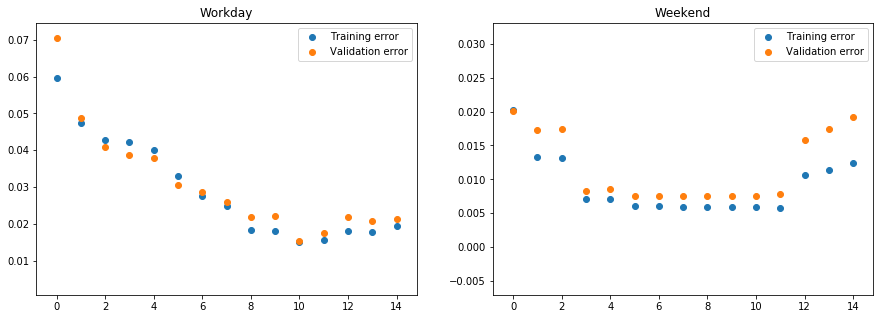

In [12]:
# Plot the training and validation errors

y = [deg for deg in range(15)]
print(len(y), len(tr_errors), len(val_errors))
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(5)

axs[0].set_title("Workday")
axs[1].set_title("Weekend")
axs[0].scatter(y, tr_errors[0], label="Training error")
axs[0].scatter(y, val_errors[0], label="Validation error")
axs[1].scatter(y, tr_errors[1], label="Training error")
axs[1].scatter(y, val_errors[1], label="Validation error")
axs[0].legend()
axs[1].legend()
plt.show()


Looks like a degree of 10 is good for the workdays, while a degree of 5 is sufficient for the weekends. 

Let's plot these models, both on the training and validatin data, as well as the rest of the data:

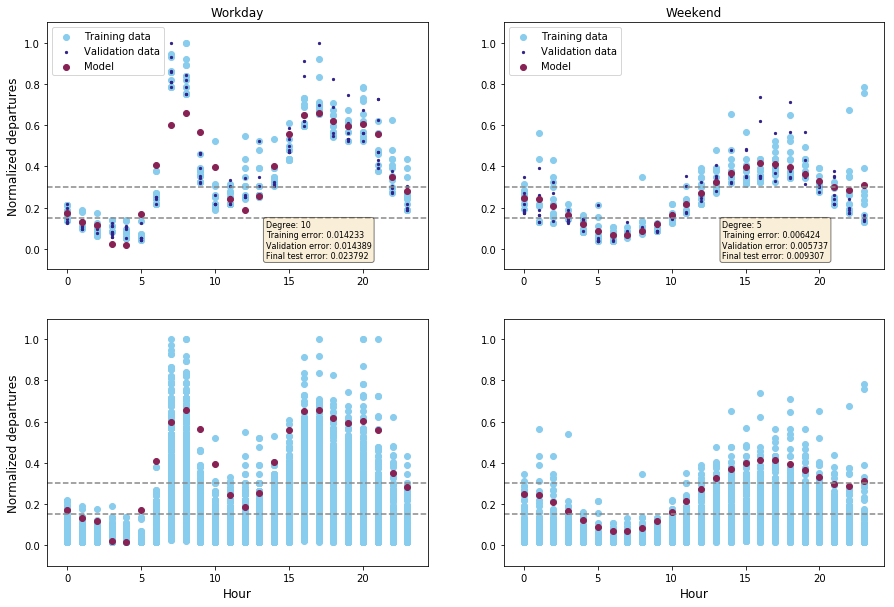

In [13]:
# Do the same thing as above, but split days into two categories: workday and weekend (0 and 1)

# Polynomial fit for the data where only the 10 max departure datapoints are taken into account for each hour during each weekday

nlargest = 20
data_largest = data.groupby(["Weekday classifier", "Hour"])["Normalized departures"].nlargest(nlargest)

fig, axs = plt.subplots(2, 2)
fig.set_figwidth(15)
fig.set_figheight(10)
for day in range(2):

    # Read in the data for polynomial regression
    y = data_largest[day].values
    X = data_largest[day].index.get_level_values(0).to_numpy().reshape(-1, 1)

    # Split data into training, validation and testing sets
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.25, random_state=42)

    # Check whether it's a workday or weekday
    title = ""
    if day == 0:
        title = "Workday"
        deg = 10
    else:
        title = "Weekend"
        deg = 5

    poly = PolynomialFeatures(degree=deg)


    # Train the model
    X_train_poly = poly.fit_transform(X_train)
    lin_regr = LinearRegression(fit_intercept=False)
    lin_regr.fit(X_train_poly, y_train)
    y_pred_train = lin_regr.predict(X_train_poly)
    tr_error = mean_squared_error(y_train, y_pred_train)

    # Validate the model
    X_val_poly = poly.fit_transform(X_val)
    y_pred_val = lin_regr.predict(X_val_poly)
    val_error = mean_squared_error(y_val, y_pred_val)

    # Test the model
    X_test_poly = poly.fit_transform(X_test)
    y_pred_test = lin_regr.predict(X_test_poly)
    test_error = mean_squared_error(y_test, y_pred_test)

    
    # The plot thickens
    X_fit = np.linspace(0, 23, 24) 
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    text_str = "Degree: {:d}".format(deg) + "\nTraining error: {:.6f}".format(
        tr_error) + "\nValidation error: {:.6f}".format(val_error) + "\nFinal test error: {:.6f}".format(test_error)
    axs[0, day].text(0.575, 0.2, text_str, transform=axs[0, day].transAxes,
                    fontsize=8, verticalalignment="top", bbox=props)

    axs[0, day].scatter(X_train, y_train, color="#88CCEE", label="Training data")
    axs[0, day].scatter(X_val, y_val, s=5, color="#332288", label="Validation data")
    axs[0, day].set_title(title)
    axs[0, day].scatter(X_fit, lin_regr.predict(poly.transform(X_fit.reshape(-1, 1))), color="#882255",label="Model")
    axs[0, day].axhline(y=0.15, color='#888888', linestyle='--')
    axs[0, day].axhline(y=0.30, color='#888888', linestyle='--')
    axs[0, day].legend(loc='upper left', prop={'size': 10})
    axs[0, day].set_ylim(-0.1, 1.1)

    y = data[data["Weekday classifier"] ==day]["Normalized departures"].to_numpy()
    X = data[data["Weekday classifier"]==day].Hour.to_numpy().reshape(-1,1)

    axs[1, day].scatter(X, y, color="#88CCEE")
    axs[1, day].scatter(X_fit, lin_regr.predict(poly.transform(X_fit.reshape(-1, 1))), color="#882255",label="Model")
    axs[1, day].axhline(y=0.15, color='#888888', linestyle='--')
    axs[1, day].axhline(y=0.30, color='#888888', linestyle='--')
    axs[1, day].set_ylim(-0.1, 1.1)

axs[0, 0].set_ylabel("Normalized departures", fontsize=12)
axs[1, 0].set_ylabel("Normalized departures", fontsize=12)
axs[1, 0].set_xlabel("Hour", fontsize=12)
axs[1, 1].set_xlabel("Hour", fontsize=12)

plt.savefig("polynomial-result.jpg", dpi=300, bbox_inches="tight")
plt.show()


Now let's categorize the departures into a low, medium and high amount of interactions at the station:

In [27]:
# Categorize departures
departure_categories = [0, 1, 2]
cut_bins = [0, 0.15, 0.35, 1.0]
categorized_departures = pd.cut(data['Departures'], bins=cut_bins, labels=departure_categories, include_lowest=True)

data["Categorized departures"] = categorized_departures
